In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file CSV
file_path = "vietnam_provinces_coordinates.csv"
df = pd.read_csv(file_path)

# Kiểm tra dữ liệu
print(df.head())  # Xem 5 dòng đầu để kiểm tra

# Lọc bỏ các dòng có giá trị "N/A" hoặc "Error" trong cột Latitude và Longitude
df = df[df['Latitude'].apply(lambda x: isinstance(x, (int, float)))]
df = df[df['Longitude'].apply(lambda x: isinstance(x, (int, float)))]

# Chuyển đổi kiểu dữ liệu sang float
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

# Tạo biểu đồ
plt.figure(figsize=(10, 12))  # Kích thước bản đồ

# Vẽ các điểm đại diện cho từng tỉnh
plt.scatter(df['Longitude'], df['Latitude'], color='red', s=20, label='Provinces')

# Thêm nhãn cho từng điểm (tên tỉnh)
for i, row in df.iterrows():
    plt.text(row['Longitude'], row['Latitude'], row['Province'], fontsize=8, ha='right')

# Thiết lập tiêu đề và nhãn trục
plt.title("Bản đồ các tỉnh Việt Nam", fontsize=16)
plt.xlabel("Kinh độ (Longitude)", fontsize=12)
plt.ylabel("Vĩ độ (Latitude)", fontsize=12)

# Thêm lưới (grid) để dễ nhìn
plt.grid(True, linestyle='--', alpha=0.7)

# Thêm chú thích
plt.legend()

# Điều chỉnh giới hạn trục để phù hợp với Việt Nam
plt.xlim(101, 114)  # Kinh độ Việt Nam khoảng từ 102°E đến 114°E
plt.ylim(8, 24)    # Vĩ độ Việt Nam khoảng từ 8°N đến 23°N

# Hiển thị bản đồ
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'vietnam_provinces_coordinates.csv'

Đường đi tối ưu: Hà Giang -> Tuyên Quang -> Vĩnh Phúc -> Hà Nội -> TP Hồ Chí Minh -> Đồng Nai
Tổng chi phí: 386.71
Đi từ Hà Giang đến Tuyên Quang bằng truck
Đi từ Tuyên Quang đến Vĩnh Phúc bằng truck
Đi từ Vĩnh Phúc đến Hà Nội bằng truck
Đi từ Hà Nội đến TP Hồ Chí Minh bằng plane
Đi từ TP Hồ Chí Minh đến Đồng Nai bằng truck


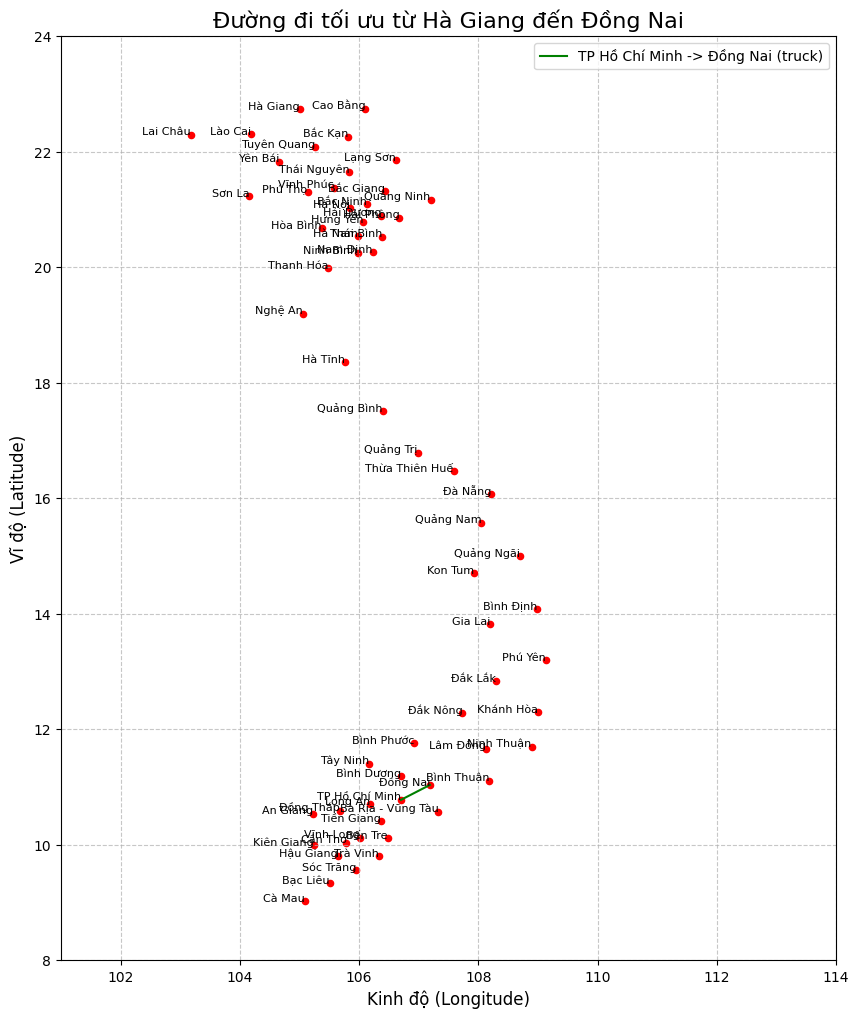

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import heapq
import math
import numpy as np

# Đọc dữ liệu tọa độ
coords_df = pd.read_csv("main_thread/data/vietnam_provinces_coordinates.csv")

# Xóa các giá trị không hợp lệ trong tọa độ
coords_df = coords_df[coords_df['Latitude'].apply(lambda x: isinstance(x, (int, float)))]
coords_df = coords_df[coords_df['Longitude'].apply(lambda x: isinstance(x, (int, float)))]
coords_df['Latitude'] = coords_df['Latitude'].astype(float)
coords_df['Longitude'] = coords_df['Longitude'].astype(float)

# Danh sách tỉnh
provinces = [
    "Hà Nội", "TP Hồ Chí Minh", "Hải Phòng", "Đà Nẵng", "Cần Thơ", "Hà Giang", "Cao Bằng",
    "Lai Châu", "Lào Cai", "Tuyên Quang", "Lạng Sơn", "Bắc Kạn", "Thái Nguyên", "Yên Bái",
    "Sơn La", "Phú Thọ", "Vĩnh Phúc", "Quảng Ninh", "Bắc Giang", "Bắc Ninh", "Hải Dương",
    "Hưng Yên", "Hòa Bình", "Hà Nam", "Nam Định", "Thái Bình", "Ninh Bình", "Thanh Hóa",
    "Nghệ An", "Hà Tĩnh", "Quảng Bình", "Quảng Trị", "Thừa Thiên Huế", "Quảng Nam",
    "Quảng Ngãi", "Bình Định", "Phú Yên", "Khánh Hòa", "Ninh Thuận", "Bình Thuận", "Kon Tum",
    "Gia Lai", "Đắk Lắk", "Đắk Nông", "Lâm Đồng", "Bình Phước", "Tây Ninh", "Bình Dương",
    "Đồng Nai", "Bà Rịa - Vũng Tàu", "Long An", "Tiền Giang", "Bến Tre", "Trà Vinh",
    "Vĩnh Long", "Đồng Tháp", "An Giang", "Kiên Giang", "Hậu Giang", "Sóc Trăng",
    "Bạc Liêu", "Cà Mau"
]

# Dictionary tỉnh lân cận với tên có dấu
province_neighbor = {
    "Lai Châu": ["Điện Biên", "Lào Cai", "Sơn La", "Yên Bái"],
    "Yên Bái": ["Lào Cai", "Lai Châu", "Sơn La", "Hà Giang", "Phú Thọ", "Tuyên Quang"],
    "Điện Biên": ["Lai Châu", "Sơn La"],
    "Thanh Hóa": ["Sơn La", "Nghệ An", "Ninh Bình", "Hòa Bình"],
    "Nghệ An": ["Hà Tĩnh", "Thanh Hóa"],
    "Quảng Bình": ["Hà Tĩnh", "Quảng Trị"],
    "Hà Tĩnh": ["Nghệ An", "Quảng Bình"],
    "Thừa Thiên Huế": ["Quảng Trị", "Đà Nẵng", "Quảng Nam"],
    "Quảng Trị": ["Quảng Bình", "Thừa Thiên Huế"],
    "Đà Nẵng": ["Thừa Thiên Huế", "Quảng Nam"],
    "Quảng Nam": ["Đà Nẵng", "Thừa Thiên Huế", "Kon Tum", "Quảng Ngãi"],
    "Kon Tum": ["Quảng Nam", "Quảng Ngãi", "Gia Lai"],
    "Quảng Ngãi": ["Kon Tum", "Quảng Nam", "Bình Định"],
    "Gia Lai": ["Kon Tum", "Bình Định", "Phú Yên", "Đắk Lắk"],
    "Bình Định": ["Quảng Ngãi", "Gia Lai", "Phú Yên"],
    "Đắk Lắk": ["Đắk Nông", "Lâm Đồng", "Khánh Hòa", "Phú Yên", "Gia Lai"],
    "Phú Yên": ["Gia Lai", "Bình Định", "Đắk Lắk", "Khánh Hòa"],
    "Khánh Hòa": ["Đắk Lắk", "Phú Yên", "Lâm Đồng", "Ninh Thuận"],
    "Đắk Nông": ["Đắk Lắk", "Lâm Đồng", "Bình Phước"],
    "Lâm Đồng": ["Đắk Lắk", "Đắk Nông", "Bình Phước", "Đồng Nai", "Bình Thuận", "Ninh Thuận", "Khánh Hòa"],
    "Ninh Thuận": ["Lâm Đồng", "Khánh Hòa", "Bình Thuận"],
    "Bình Phước": ["Tây Ninh", "Bình Dương", "Đồng Nai", "Đắk Nông", "Lâm Đồng"],
    "Đồng Nai": ["Lâm Đồng", "Bình Phước", "Bình Thuận", "TP Hồ Chí Minh", "Bà Rịa - Vũng Tàu", "Bình Dương"],
    "Bình Thuận": ["Bà Rịa - Vũng Tàu", "Lâm Đồng", "Ninh Thuận", "Đồng Nai"],
    "Tây Ninh": ["Long An", "TP Hồ Chí Minh", "Bình Dương", "Bình Phước"],
    "Bình Dương": ["Tây Ninh", "TP Hồ Chí Minh", "Đồng Nai", "Bình Phước"],
    "TP Hồ Chí Minh": ["Tây Ninh", "Bình Dương", "Đồng Nai", "Long An", "Bà Rịa - Vũng Tàu"],
    "Bà Rịa - Vũng Tàu": ["TP Hồ Chí Minh", "Đồng Nai", "Bình Thuận"],
    "Long An": ["Tây Ninh", "TP Hồ Chí Minh", "Đồng Tháp", "Tiền Giang"],
    "Đồng Tháp": ["Long An", "Tiền Giang", "Vĩnh Long", "Cần Thơ", "An Giang"],
    "Tiền Giang": ["Long An", "Đồng Tháp", "Vĩnh Long", "Bến Tre"],
    "Bến Tre": ["Vĩnh Long", "Tiền Giang", "Trà Vinh"],
    "An Giang": ["Kiên Giang", "Cần Thơ", "Đồng Tháp"],
    "Cần Thơ": ["Kiên Giang", "An Giang", "Đồng Tháp", "Vĩnh Long", "Hậu Giang"],
    "Vĩnh Long": ["Cần Thơ", "Đồng Tháp", "Bến Tre", "Trà Vinh", "Hậu Giang"],
    "Trà Vinh": ["Bến Tre", "Vĩnh Long", "Sóc Trăng"],
    "Sóc Trăng": ["Hậu Giang", "Bạc Liêu", "Trà Vinh"],
    "Hậu Giang": ["Kiên Giang", "Bạc Liêu", "Sóc Trăng", "Cần Thơ", "Vĩnh Long"],
    "Kiên Giang": ["An Giang", "Cần Thơ", "Hậu Giang", "Bạc Liêu", "Cà Mau"],
    "Bạc Liêu": ["Kiên Giang", "Hậu Giang", "Sóc Trăng", "Cà Mau"],
    "Cà Mau": ["Kiên Giang", "Bạc Liêu"],
    "Hà Nội": ["Phú Thọ", "Hòa Bình", "Bắc Giang", "Vĩnh Phúc", "Bắc Ninh", "Hưng Yên", "Hà Nam"],
    "Phú Thọ": ["Sơn La", "Yên Bái", "Hòa Bình", "Hà Nội", "Vĩnh Phúc", "Tuyên Quang"],
    "Hòa Bình": ["Ninh Bình", "Thanh Hóa", "Hà Nam", "Hà Nội", "Phú Thọ", "Sơn La"],
    "Bắc Giang": ["Quảng Ninh", "Hải Dương", "Bắc Ninh", "Hà Nội", "Thái Nguyên", "Lạng Sơn"],
    "Vĩnh Phúc": ["Phú Thọ", "Hà Nội", "Thái Nguyên", "Tuyên Quang"],
    "Bắc Ninh": ["Hà Nội", "Hưng Yên", "Hải Dương", "Bắc Giang"],
    "Hưng Yên": ["Hà Nội", "Bắc Ninh", "Hải Dương", "Thái Bình", "Hà Nam"],
    "Hà Nam": ["Hà Nội", "Hưng Yên", "Thái Bình", "Nam Định", "Ninh Bình", "Hòa Bình"],
    "Hải Phòng": ["Thái Bình", "Quảng Ninh"],
    "Hải Dương": ["Bắc Ninh", "Hưng Yên", "Thái Bình", "Hải Phòng", "Quảng Ninh", "Bắc Giang"],
    "Nam Định": ["Ninh Bình", "Hà Nam", "Thái Bình"],
    "Thái Nguyên": ["Tuyên Quang", "Bắc Kạn", "Lạng Sơn", "Bắc Giang", "Hà Nội", "Vĩnh Phúc"],
    "Thái Bình": ["Nam Định", "Hà Nam", "Hưng Yên", "Hải Dương", "Hải Phòng"],
    "Quảng Ninh": ["Hải Dương", "Hải Phòng", "Bắc Giang", "Lạng Sơn"],
    "Lạng Sơn": ["Quảng Ninh", "Bắc Giang", "Thái Nguyên", "Bắc Kạn", "Cao Bằng"],
    "Ninh Bình": ["Hòa Bình", "Thanh Hóa", "Nam Định", "Hà Nam"],
    "Lào Cai": ["Lai Châu", "Yên Bái", "Hà Giang"],
    "Cao Bằng": ["Hà Giang", "Bắc Kạn", "Lạng Sơn"],
    "Hà Giang": ["Cao Bằng", "Tuyên Quang", "Yên Bái", "Lào Cai"],
    "Tuyên Quang": ["Hà Giang", "Bắc Kạn", "Thái Nguyên", "Vĩnh Phúc", "Phú Thọ", "Yên Bái"],
    "Bắc Kạn": ["Tuyên Quang", "Thái Nguyên", "Lạng Sơn", "Cao Bằng"],
    "Sơn La": ["Điện Biên", "Yên Bái", "Phú Thọ", "Hòa Bình", "Thanh Hóa"],
}

# Chia miền theo vĩ độ
def classify_region(lat):
    if lat > 18.5:
        return "North"
    elif lat > 13:
        return "Central"
    else:
        return "South"

coords_df['Region'] = coords_df['Latitude'].apply(classify_region)

# Chọn kho chính
warehouses = {
    "North": "Hà Nội",
    "Central": "Đà Nẵng",
    "South": "TP Hồ Chí Minh"
}

# Hàm tính khoảng cách Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Tạo đồ thị khoảng cách từ tọa độ
def create_distance_graph(df):
    provinces = df['Province'].tolist()
    graph = {}
    for province in provinces:
        graph[province] = {}
        if province in province_neighbor:
            for neighbor in province_neighbor[province]:
                if neighbor in provinces:
                    lat1, lon1 = df[df['Province'] == province][['Latitude', 'Longitude']].iloc[0]
                    lat2, lon2 = df[df['Province'] == neighbor][['Latitude', 'Longitude']].iloc[0]
                    distance = haversine(lat1, lon1, lat2, lon2)
                    graph[province][neighbor] = distance
        if province in warehouses.values():
            for warehouse in warehouses.values():
                if warehouse != province:
                    lat1, lon1 = df[df['Province'] == province][['Latitude', 'Longitude']].iloc[0]
                    lat2, lon2 = df[df['Province'] == warehouse][['Latitude', 'Longitude']].iloc[0]
                    distance = haversine(lat1, lon1, lat2, lon2)
                    graph[province][warehouse] = distance
    return graph

distance_graph = create_distance_graph(coords_df)

# Hàm tính chi phí vận chuyển
def calculate_cost(distance, transport_mode, storage_time=0):
    if transport_mode == "truck":
        return (distance / 60) * 35  # Xe tải
    elif transport_mode == "plane":
        return (distance / 800 + storage_time) * 160  # Máy bay
    return float('inf')

# Thuật toán A*
def a_star(start, goal, weight, max_time=48):
    if start not in coords_df['Province'].values or goal not in coords_df['Province'].values:
        raise ValueError(f"Không tìm thấy tỉnh '{start}' hoặc '{goal}' trong dữ liệu.")

    open_set = [(0, start, [], 0, [])]  # (f_score, node, path, total_time, transport_modes)
    g_score = {start: 0}
    f_score = {start: haversine(*coords_df[coords_df['Province'] == start][['Latitude', 'Longitude']].iloc[0],
                                *coords_df[coords_df['Province'] == goal][['Latitude', 'Longitude']].iloc[0])}
    visited = set()

    while open_set:
        f, current, path, total_time, transport_modes = heapq.heappop(open_set)
        if current == goal and weight <= 10:
            return path + [current], g_score[current], transport_modes

        if current in visited:
            continue
        visited.add(current)

        current_region = coords_df[coords_df['Province'] == current]['Region'].iloc[0]
        goal_region = coords_df[coords_df['Province'] == goal]['Region'].iloc[0]

        neighbors = province_neighbor.get(current, [])
        if current in warehouses.values():
            neighbors = list(set(neighbors + list(warehouses.values())))

        for neighbor in neighbors:
            if neighbor not in coords_df['Province'].values or neighbor == current:
                continue

            distance = distance_graph.get(current, {}).get(neighbor, float('inf'))
            if distance == float('inf'):
                continue

            transport_mode = "truck" if neighbor in province_neighbor.get(current, []) else "plane"
            if transport_mode == "plane" and distance < 800:
                continue

            time = distance / (60 if transport_mode == "truck" else 800)
            new_total_time = total_time + time
            if new_total_time > max_time:
                continue

            temp_g_score = g_score[current] + calculate_cost(distance, transport_mode)
            new_transport_modes = transport_modes + [(current, neighbor, transport_mode)]

            if new_total_time > 48:
                temp_g_score *= 1.1

            if neighbor not in g_score or temp_g_score < g_score[neighbor]:
                g_score[neighbor] = temp_g_score
                h = haversine(*coords_df[coords_df['Province'] == neighbor][['Latitude', 'Longitude']].iloc[0],
                              *coords_df[coords_df['Province'] == goal][['Latitude', 'Longitude']].iloc[0])
                f_score[neighbor] = temp_g_score + h
                heapq.heappush(open_set, (f_score[neighbor], neighbor, path + [current], new_total_time, new_transport_modes))

    return None, float('inf'), []

# Trực quan hóa
def visualize_path(start, goal, path, cost, transport_modes):
    fig, ax = plt.subplots(figsize=(10, 12))
    plt.scatter(coords_df['Longitude'], coords_df['Latitude'], color='red', s=20, label='Provinces')
    for i, row in coords_df.iterrows():
        plt.text(row['Longitude'], row['Latitude'], row['Province'], fontsize=8, ha='right')

    if path:
        path_coords = coords_df[coords_df['Province'].isin(path)][['Latitude', 'Longitude']].values
        ax.plot(path_coords[:, 1], path_coords[:, 0], 'b-', label=f'Total Cost: {cost:.2f}')

    plt.title(f"Đường đi tối ưu từ {start} đến {goal}", fontsize=16)
    plt.xlabel("Kinh độ (Longitude)", fontsize=12)
    plt.ylabel("Vĩ độ (Latitude)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xlim(101, 114)
    plt.ylim(8, 24)

    def update(frame):
        ax.clear()
        ax.scatter(coords_df['Longitude'], coords_df['Latitude'], color='red', s=20)
        for i, row in coords_df.iterrows():
            ax.text(row['Longitude'], row['Latitude'], row['Province'], fontsize=8, ha='right')

        if frame < len(transport_modes):
            start_prov, end_prov, mode = transport_modes[frame]
            sub_path = [start_prov, end_prov]
            sub_coords = coords_df[coords_df['Province'].isin(sub_path)][['Latitude', 'Longitude']].values
            color = 'g-' if mode == "truck" else 'b--'  # Xanh cho xe tải, xanh đậm nét đứt cho máy bay
            ax.plot(sub_coords[:, 1], sub_coords[:, 0], color, label=f'{start_prov} -> {end_prov} ({mode})')
            ax.legend()

        ax.set_xlim(101, 114)
        ax.set_ylim(8, 24)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_title(f"Đường đi tối ưu từ {start} đến {goal}", fontsize=16)
        ax.set_xlabel("Kinh độ (Longitude)", fontsize=12)
        ax.set_ylabel("Vĩ độ (Latitude)", fontsize=12)

    if path:
        ani = FuncAnimation(fig, update, frames=len(transport_modes), repeat=False)
        ani.save("path_animation.gif", writer='pillow', fps=1)

    plt.show()

# Chạy bài toán
start_province = "Hà Giang"
goal_province = "Đồng Nai"
weight = 5  # 5 tấn hàng

try:
    path, cost, transport_modes = a_star(start_province, goal_province, weight)
    if path:
        print(f"Đường đi tối ưu: {' -> '.join(path)}")
        print(f"Tổng chi phí: {cost:.2f}")
        for start_p, end_p, mode in transport_modes:
            print(f"Đi từ {start_p} đến {end_p} bằng {mode}")
        visualize_path(start_province, goal_province, path, cost, transport_modes)
    else:
        print("Không tìm thấy đường đi phù hợp!")
except ValueError as e:
    print(e)